<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/docs/compare_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# command line
以下のpipセクション終了後に必ず**ランタイムの再起動**を行うこと

In [1]:
!pip uninstall tbb
!pip install scanpy scikit-misc tbb
#!pip install --upgrade umap-learn
# install ldvae
!git clone https://github.com/kicysh/final_task_of_world_model_lecture_2021/
!pip install final_task_of_world_model_lecture_2021/package/. --use-feature=in-tree-build

     |████████████████████████████████| 2.0 MB 8.7 MB/s 
     |████████████████████████████████| 8.8 MB 35.4 MB/s 
     |████████████████████████████████| 88 kB 10.1 MB/s 
     |████████████████████████████████| 96 kB 7.2 MB/s 
     |████████████████████████████████| 11.2 MB 70.3 MB/s 
     |████████████████████████████████| 900 kB 85.3 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=0c81c462b047fd786d72688c420c2453f9313e6f78bd430c5948d840835c4fde
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=839a5ecd3fa067c17a9711e33df4ebe738bc3f78a1089c2b2e603eba35ff8189
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created

     |████████████████████████████████| 4.0 MB 7.4 MB/s 
Cloning into 'final_task_of_world_model_lecture_2021'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (251/251), done.
Receiving objects: 100% (257/257), 26.25 MiB | 8.69 MiB/s, done.
remote: Total 257 (delta 55), reused 0 (delta 0), pack-reused 0
Resolving deltas: 100% (55/55), done.
Processing ./final_task_of_world_model_lecture_2021/package
  Created wheel for LDVAE: filename=LDVAE-0.1.0-py3-none-any.whl size=3274 sha256=528365382b292d8188765b4f8e3d1e123e934e19e4029a0aaf15a85eea1d617d
  Stored in directory: /tmp/pip-ephem-wheel-cache-0fbiw7tu/wheels/e2/2f/44/da18d64c7ac8950bd4f266d145db33398678d80aff1a4f488f
Successfully built LDVAE


In [2]:
!mkdir data figures intermediate

import gdown
gdown.download('https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb', '/content/data/train_data.h5ad', quiet=False,)


Downloading...
From: https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb
To: /content/data/train_data.h5ad
100%|██████████| 23.5M/23.5M [00:00<00:00, 126MB/s]


'/content/data/train_data.h5ad'

In [3]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
anndata                       0.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.0
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4   

# setting


In [1]:
import ldvae

import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
#from torch import logsumexp
#from torch.distributions import Normal, kl_divergence
import sklearn.model_selection

import matplotlib.pyplot as plt

import scanpy as sc

In [2]:
# global
USE_CUDA = True

# model params
SETTING_HIDDEN_DIMS = (128,)
SETTING_LATENT_DIM = 20
SETTING_USE_NORM = True

SETTING_BATCH_SIZE = 1024

SETTING_N_TOP_GENES = 1000

SETTING_NUM_WORKERS = 4

SETTING_N_EPOCHS = 100
SETTING_N_SPLITS = 5

#SETTING_TRAIN_RATE = 0.8
#SETTING_VAL_RATE = 0.2

DATA_PATH = '/content/data/train_data.h5ad'
#W_CSV_PATH = '/content/intermediate/w.csv'
INTERMEDIATE_PATH = '/content/intermediate'

RANDOM_SEED = 42

In [3]:
# 再現性のため
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

GENERATOR = torch.Generator()
GENERATOR.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# data

## read data

In [4]:
adata = sc.read_h5ad(DATA_PATH)
adata

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

## 前処理

In [5]:
sc.pp.highly_variable_genes(adata,n_top_genes=SETTING_N_TOP_GENES ,flavor='seurat_v3')
print(adata)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


In [6]:
gene_index = adata.var[adata.var['highly_variable']].index
adata_df = adata.to_df()[gene_index]


## create dataset

In [7]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata: np.array, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

## create dataloader

In [8]:
# dataloder
dataset = GenesDataset(adata_df.values)
dataloader_all_train = torch.utils.data.DataLoader(
                            dataset,
                            batch_size=SETTING_BATCH_SIZE,
                            shuffle=True,
                            num_workers=SETTING_NUM_WORKERS,
                            pin_memory=True, 
                            worker_init_fn=seed_worker, 
                            generator=GENERATOR
                                        )
dataloader_all = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=SETTING_BATCH_SIZE,
                        shuffle=False
                                        )

# model

## define model

In [9]:
SETTING_MODELS = [
                  {'model_name': 'model_1',
                   'hidden_dims': (128,),
                   'hidden_l_dims': (128,),
                   'latent_dim': 10,
                   'drop_use': True,
                   'drop_rate': 0.1,
                   'norm_use': True,},
                  
                  {'model_name': 'model_2',
                   'hidden_dims': (128,),
                   'hidden_l_dims': (128,),
                   'latent_dim': 10,
                   'drop_use': True,
                   'drop_rate': 0.1,
                   'norm_use': False},
                  
                  {'model_name': 'model_3',
                   'hidden_dims': (128,32,),
                   'hidden_l_dims': (128,),
                   'latent_dim': 8,
                   'drop_use': True,
                   'drop_rate': 0.1,
                   'norm_use': True},
]

## serch best epoch

In [11]:
n_epochs  = SETTING_N_EPOCHS
best_models = []

device = 'cuda'  if USE_CUDA else 'cpu'

for model_kwds in SETTING_MODELS:
    model_name = model_kwds['model_name']
    kf = sklearn.model_selection.KFold(n_splits=SETTING_N_SPLITS,
                                    shuffle=True,
                                    random_state= RANDOM_SEED)
    _losses_each_fold = []
    for _fold, (index_train, index_valid) in enumerate(kf.split(adata_df.values)):
        # dataset and dataloader===========================================
        dataset_train = torch.utils.data.dataset.Subset(dataset, index_train)
        dataloader_train = torch.utils.data.DataLoader(
                                                dataset_train,
                                                batch_size=SETTING_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=SETTING_NUM_WORKERS,
                                                pin_memory=True, 
                                                worker_init_fn=seed_worker, 
                                                generator=GENERATOR
                                                )
        dataset_valid   = torch.utils.data.dataset.Subset(dataset, index_valid)
        dataloader_valid = torch.utils.data.DataLoader(
                                                dataset_valid,
                                                batch_size=SETTING_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=SETTING_NUM_WORKERS,
                                                pin_memory=True, 
                                                worker_init_fn=seed_worker, 
                                                generator=GENERATOR
                                                )
        # model====================================
        model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                            hidden_dims= model_kwds['hidden_dims'],
                            hidden_l_dims = model_kwds['hidden_l_dims'],
                            latent_dim = model_kwds['latent_dim'],
                            drop_use = model_kwds['drop_use'],
                            drop_rate = model_kwds['drop_rate'],
                            norm_use = model_kwds['norm_use'])
        model.set_local_l_mean_and_var(adata_df.values)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=7e-3)

        _losses_each_epoch = []
        for epoch in range(n_epochs):
            losses = []

            model.train()
            for x in dataloader_train:
                x = x.to(device)

                optimizer.zero_grad()
                # forawrd and loss
                reconst, kl_l ,kl_z = model.loss(x)
                loss = torch.mean(-reconst+kl_l +kl_z)

                nn.utils.clip_grad_norm_(model.parameters(), 0.25)
                loss.backward()
                optimizer.step()

                losses.append(loss.cpu().detach().numpy())


            _losses_each_batch = []
            model.eval()
            for x in dataloader_valid:

                x = x.to(device)
                reconst, kl_l ,kl_z = model.loss(x)

                _losses_each_batch.append(
                    torch.mean(-reconst).cpu().detach().numpy()
                    + torch.mean(kl_l).cpu().detach().numpy()
                    + torch.mean(kl_z).cpu().detach().numpy())
                
            _losses_each_epoch.append(np.mean(_losses_each_batch))
            print(f'\r[{model_name}] k_fold: {_fold}/{SETTING_N_SPLITS} epoch: {epoch}/{SETTING_N_EPOCHS}', end='')
        _losses_each_fold.append(_losses_each_epoch)
    _losses_each_fold = np.array(_losses_each_fold).mean(0)
    best_epoch = _losses_each_fold.argmin() +1
    best_loss = _losses_each_fold[best_epoch-1]

    best_models.append(model_kwds)
    best_models[-1]['best_loss'] = best_loss
    best_models[-1]['best_epoch'] = best_epoch

    print(f'\r[{model_name}] best_epoch: {best_epoch} best_loss: {best_loss}')

[model_1] best_epoch: 100 best_loss: 133.22640991210938
[model_2] best_epoch: 97 best_loss: 135.27452087402344
[model_3] best_epoch: 96 best_loss: 133.8687286376953


## train

In [10]:
#best_models = SETTING_MODELS
#device = 'cuda'

In [11]:
for model_kwds in best_models:
    n_epochs = model_kwds['best_epoch']
    model_name = model_kwds['model_name']
    # model====================================
    model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                        hidden_dims= model_kwds['hidden_dims'],
                        hidden_l_dims = model_kwds['hidden_l_dims'],
                        latent_dim = model_kwds['latent_dim'],
                        drop_use = model_kwds['drop_use'],
                        drop_rate = model_kwds['drop_rate'],
                        norm_use = model_kwds['norm_use'])
    model.set_local_l_mean_and_var(adata_df.values)
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=7e-3)

    for epoch in range(n_epochs):   
        print(f'\r[{model_name}] train {epoch}/{n_epochs}', end='')
        for x in dataloader_all_train:
            x = x.to(device)

            optimizer.zero_grad()
            # forawrd and loss
            reconst, kl_l ,kl_z = model.loss(x)
            loss = torch.mean(-reconst+kl_l +kl_z)

            nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            loss.backward()
            optimizer.step()

    # output intermediate file ================================
    # output w
    _w = model.decoder[0].weight
    if model_kwds['norm_use']:
        bn = model.decoder[1]
        sigma = torch.sqrt(bn.running_var + bn.eps)
        gamma = bn.weight
        b = gamma / sigma
        bI = torch.diag(b)
        loadings = torch.matmul(bI, _w)
        loadings = loadings.detach().cpu().numpy()
    else:
        loadings = _w.detach().cpu().numpy()
    W = pd.DataFrame(loadings, index=gene_index)
    W.to_csv(f'{INTERMEDIATE_PATH}/{model_name}_w.csv')

    # output the latent variables (z)
    latent_array  = None
    model.eval()
    for x in dataloader_all:
        x = x.to(device)
        _z,_,_ = model(x)
        z_mean,_,_ = _z
        z_mean = z_mean.cpu().detach().numpy()
        if latent_array is None:
            latent_array = z_mean
        else:
            latent_array = np.concatenate([latent_array, z_mean])
    z_csv = pd.DataFrame(latent_array,index=adata_df.index)
    z_csv.to_csv(f'{INTERMEDIATE_PATH}/{model_name}_z.csv')
    print(f'\r[{model_name}] train...done, save...done')

[model_1] train...done, save...done
[model_2] train...done, save...done
[model_3] train...done, save...done


# output figures

In [12]:
%pylab inline
%config InlineBackend.figure_format ='retina'


import matplotlib.colors as mcolors

#import plotnine as p

from matplotlib.patches import Ellipse
from scipy import stats
import matplotlib.cm as cm
import anndata

import umap
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
def create_fig(X_reduced: np.ndarray,
               adata:anndata._core.anndata.AnnData,
               title: str = 'title',
               save: bool = True,
               save_name: str = 'figures/fig.pdf',
               close: bool= False
               ):
    """
    create a scatter figure form 2 dims.
    
    params
    ------
    title: str, default 'title'
        figure title
    save: bool, default True
    save_name: str, default 'figures/fig.pdf'
        If you set save to False, ignore save_name.
    close: bool, default False
        If set close to True, run plt.colse() after plt.save().
    """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,1,1)
    #ax.set_title('the 10 latent variables view with umap')
    ax.set_title(title)
    for cell_type,cell_type_color in zip(adata.obs.cell_type.values.categories,
                                         adata.uns['cell_type_colors']):
        x = X_reduced[(adata.obs.cell_type==cell_type).values,0]
        y = X_reduced[(adata.obs.cell_type==cell_type).values,1]
        ax.scatter(x, y, c=cell_type_color,s=0.5,label=cell_type,alpha=0.5)

    #ax.legend()
    ax.legend(title = "Cell Type", 
            title_fontsize = "large",
            labelspacing = 1,
            handletextpad= 0.5,
            frameon=False, # 枠を消す
            markerscale = 10, # マーカーの大きさ
            loc='upper left', # 位置の設定
            bbox_to_anchor=(1, 1) # 位置の設定
            )
    if save:
        plt.savefig(save_name, bbox_inches='tight', dpi=800)
    if close:
        plt.close()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  Futu

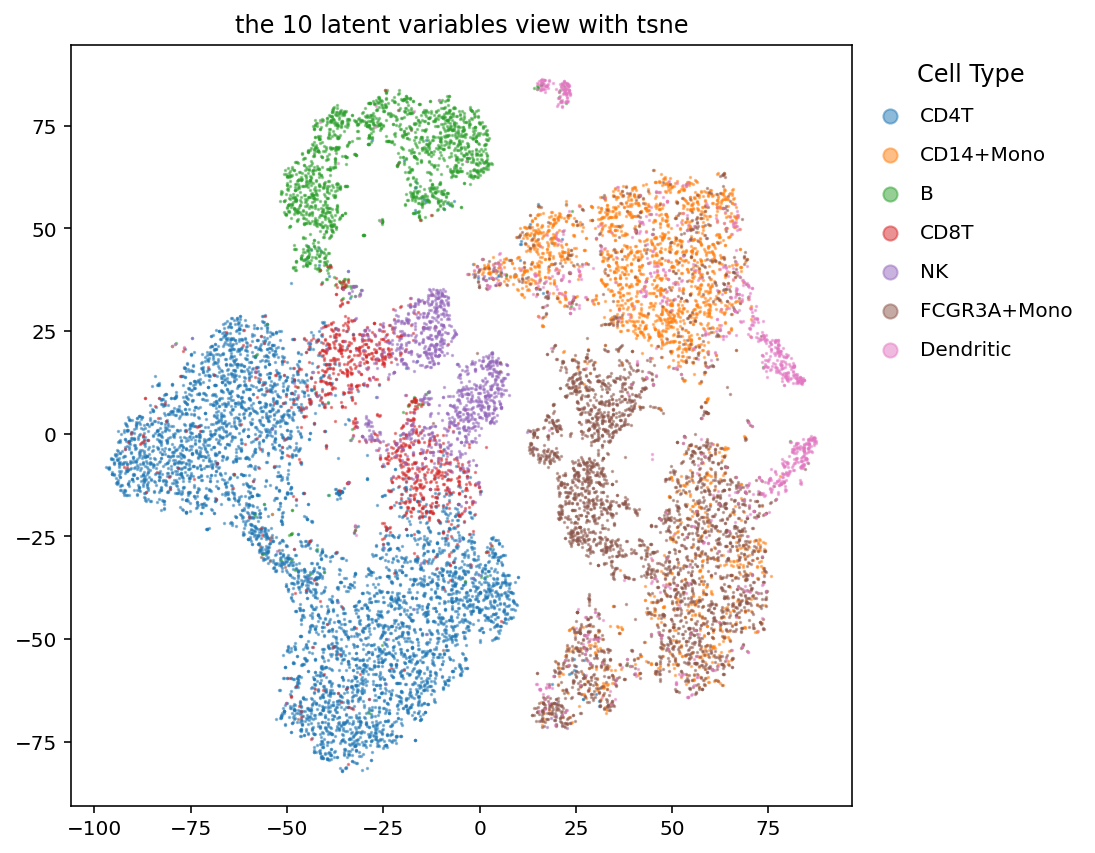

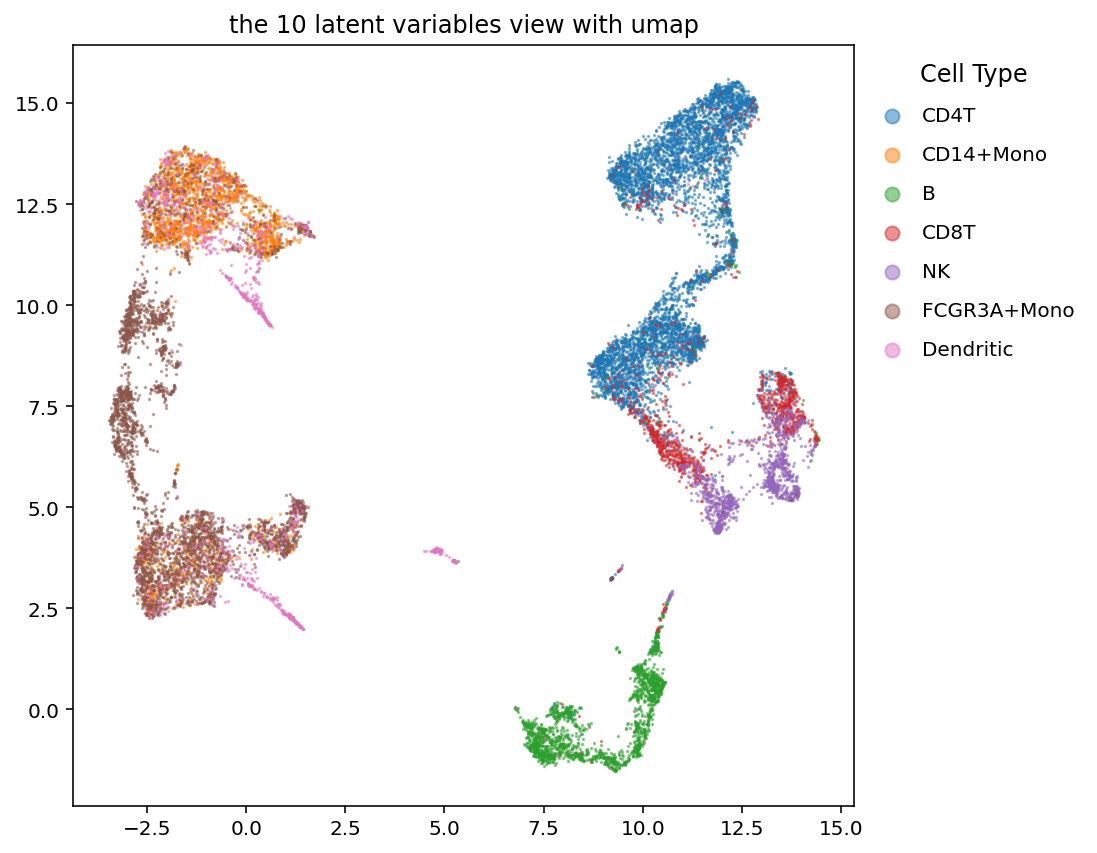

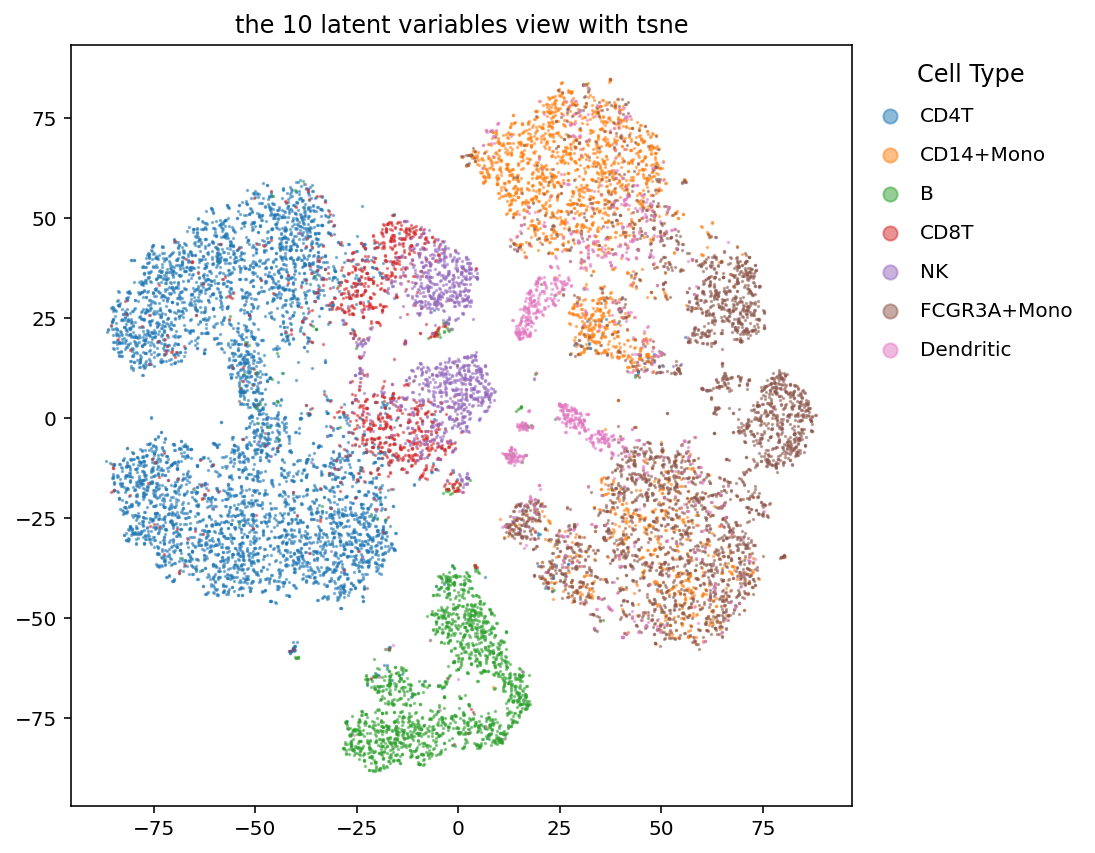

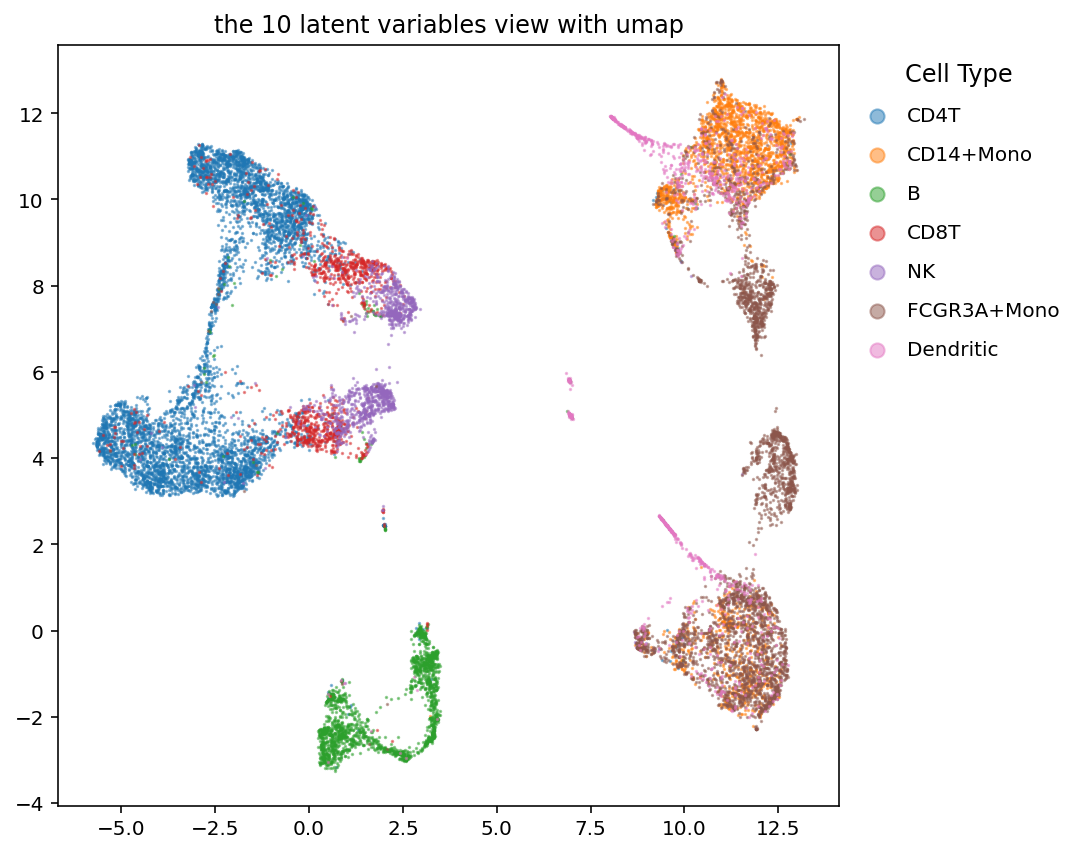

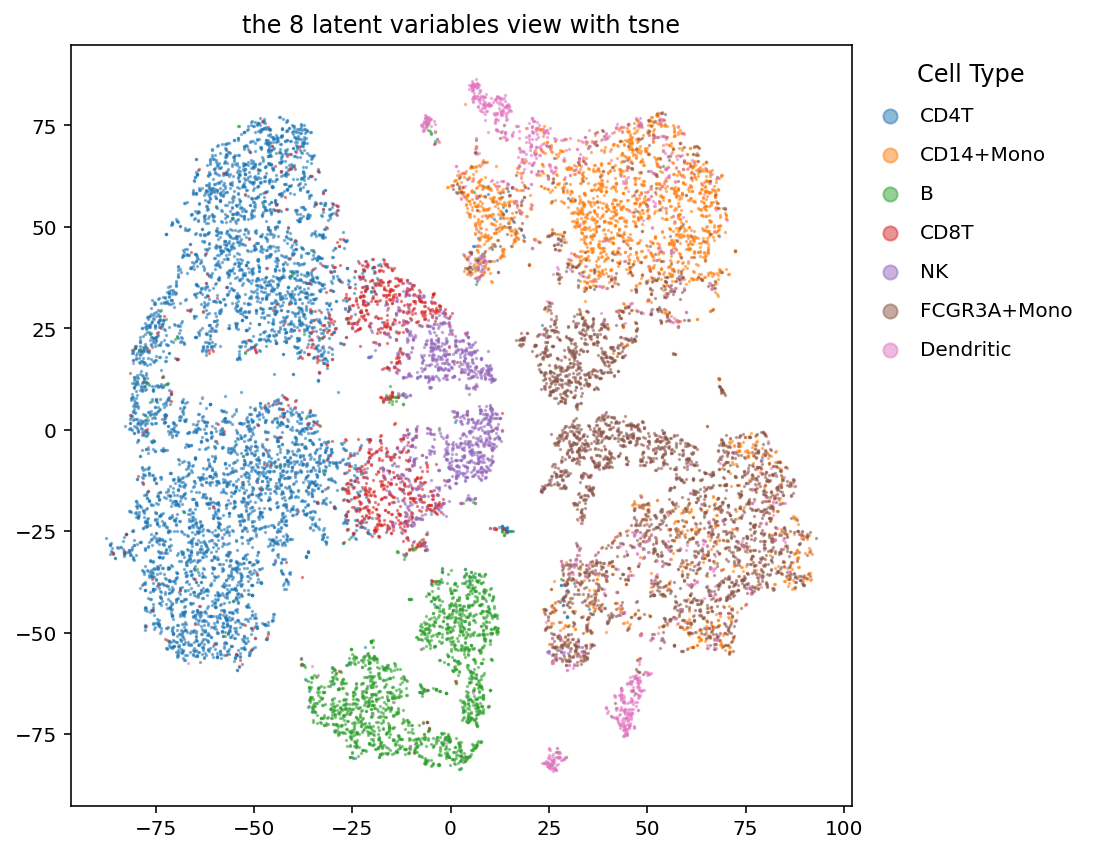

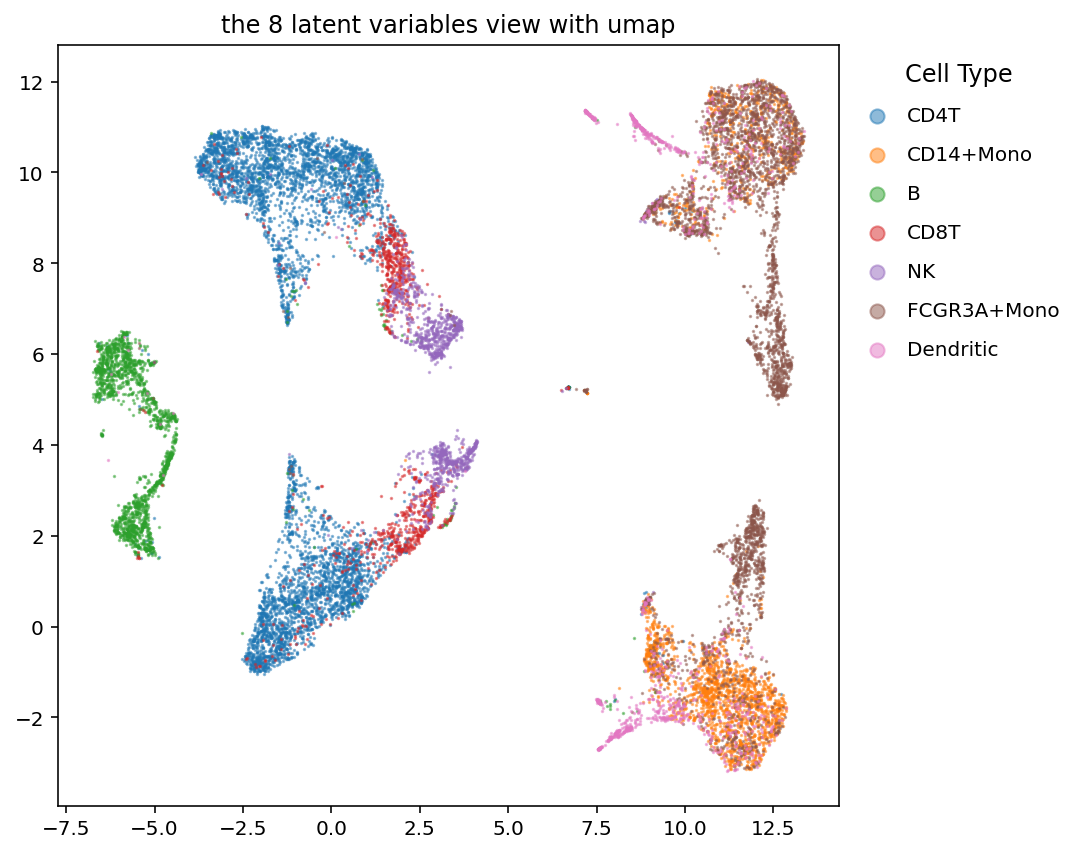

In [15]:
for model_kwds in best_models:
    model_name = model_kwds['model_name']
    latent_dim = model_kwds['latent_dim']
    w_csv_path = f'{INTERMEDIATE_PATH}/{model_name}_w.csv'
    z_csv_path = f'{INTERMEDIATE_PATH}/{model_name}_z.csv'

    w_df = pd.read_csv(w_csv_path, index_col=0)
    z_df = pd.read_csv(z_csv_path, index_col=0)

    w_df = w_df.add_prefix('w')
    z_df = z_df.add_prefix('z')

    for fig_type in ['tsne', 'umap']:
        if fig_type == 'tsne':
            X_reduced = TSNE(n_components=2, 
                             learning_rate='auto',
                             init='pca',
                             random_state=RANDOM_SEED).fit_transform(z_df.values)
        elif fig_type == 'umap':
            X_reduced = umap.UMAP().fit_transform(z_df.values)

        create_fig(X_reduced=X_reduced,
                   adata=adata,
                   title=f'the {latent_dim} latent variables view with {fig_type}',
                    save=True,
                    save_name=f'/content/figures/{model_name}_{fig_type}.pdf',
                    close=False)

# EXTRA

In [ ]:
def Z_covariance(Z):
    """
    return matrix and explained variance

    params
    -------
    Z: np.array

    return
    ------
    ZTZ: np.array
    variance_explained: np.array
    """
    #Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [ ]:
# descending order by explained variance
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]

Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
metadata = adata.obs.loc[Z_df_ordered.index].join(Z_df_ordered)

W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)
vardata = W_df_ordered

In [ ]:

print('相関係数 ===================================')
for ctype in np.unique(metadata['cell_type']):
    z_corrs = Z_df_ordered.corrwith((metadata['cell_type'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

相関係数 ===================================
[' z3: +0.57', ' z9: -0.56', 'z13: +0.27'] B
['z12: +0.54', ' z6: -0.40', 'z16: -0.32'] CD14+Mono
['z12: -0.68', ' z9: +0.59', ' z6: +0.44'] CD4T
['z13: -0.35', 'z10: +0.22', ' z6: +0.20'] CD8T
['z18: -0.46', 'z12: +0.22', ' z9: -0.18'] Dendritic
[' z2: -0.52', ' z3: -0.49', ' z6: -0.39'] FCGR3A+Mono
['z10: +0.41', 'z13: -0.35', 'z14: +0.32'] NK


In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")